# <span style="font-width:bold; font-size: 3rem; color:#1EB182;"> **Air Quality** </span><span style="font-width:bold; font-size: 3rem; color:#333;">- Part 04: Batch Inference</span>

## 🗒️ This notebook is divided into the following sections:

1. Download model and batch inference data
2. Make predictions, generate PNG for forecast
3. Store predictions in a monitoring feature group adn generate PNG for hindcast

## <span style='color:#ff5f27'> 📝 Imports

In [1]:
import sys
from pathlib import Path

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Settings are provided via Hopsworks secrets; no .env needed for this notebook.
# from mlfs import config
# settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: /Users/jesper/Documents/KTH/Skalbar_ML/mlfs-book


In [2]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from mlfs.airquality import util
import os
import numpy as np

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
today

datetime.datetime(2025, 11, 13, 17, 28, 54, 661224)

## <span style="color:#ff5f27;"> 📡 Connect to Hopsworks Feature Store </span>

In [4]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

# Read per-sensor secret via SENSOR_SLUG
SENSOR_SLUG = os.getenv("SENSOR_SLUG", "visby_bromsebrovag_8")
secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret(f"SENSOR_LOCATION_JSON_{SENSOR_SLUG.upper()}").value
location = json.loads(location_str)
country = location['country']
city = location['city']
street = location['street']
latitude = location.get('latitude')
longitude = location.get('longitude')

2025-11-13 17:28:54,675 INFO: Initializing external client
2025-11-13 17:28:54,675 INFO: Base URL: https://c.app.hopsworks.ai:443
2025-11-13 17:28:55,249 WARNING: UserWarning: The installed hopsworks client version 4.4.2 may not be compatible with the connected Hopsworks backend version 4.2.2. 
To ensure compatibility please install the latest bug fix release matching the minor version of your backend (4.2) by running 'pip install hopsworks==4.2.*'



2025-11-13 17:28:56,016 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1271996


## <span style="color:#ff5f27;">🪝 Download the model from Model Registry</span>

In [5]:
mr = project.get_model_registry()

# Load exact per-sensor model for this slug (no fallback)
model_name = f"air_quality_xgboost_model_lags_{SENSOR_SLUG}"
retrieved_model = mr.get_model(name=model_name)
if retrieved_model is None:
    raise RuntimeError(f"Model '{model_name}' not found in registry")

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

2025-11-13 17:28:57,410 WARNING: VersionWarning: No version provided for getting model `air_quality_xgboost_model_lags_visby_bromsebrovag_8`, defaulting to `1`.



Downloading: 0.000%|          | 0/521192 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/122140 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/26515 elapsed<00:00 remaining<?

In [6]:
# Loading the XGBoost regressor model and label encoder from the saved model directory
# retrieved_xgboost_model = joblib.load(saved_model_dir + "/xgboost_regressor.pkl")
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
retrieved_xgboost_model

XGBRegressor(base_score='3.555586E0', booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None,
             feature_types=['float', 'float', 'float', 'float', 'float',
                            'float', 'float'],
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## <span style="color:#ff5f27;">✨ Get Weather Forecast Features with Feature View   </span>



In [7]:
weather_fg = fs.get_feature_group(
    name='weather',
    version=1,
)
# Filter to target city and dates >= today
batch_data = weather_fg.filter((weather_fg.city == city) & (weather_fg.date >= today)).read()
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.58s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city
0,2025-11-15 00:00:00+00:00,4.10,0.0,9.826088,298.442810,visby
1,2025-11-14 00:00:00+00:00,5.50,0.0,11.681987,303.690094,visby
2,2025-11-16 00:00:00+00:00,4.90,0.0,20.150354,251.241257,visby
3,2025-11-18 00:00:00+00:00,1.95,0.0,17.068707,297.645874,visby
4,2025-11-17 00:00:00+00:00,3.70,0.0,9.511088,330.524200,visby
5,2025-11-19 00:00:00+00:00,3.55,0.0,7.704336,232.594574,visby


In [8]:
# Prepare lag features for D+1 prediction using latest history from air_quality v3
hist_fg = fs.get_feature_group(name='air_quality', version=3)
hist_df = hist_fg.filter(
    (hist_fg.city == city) & (hist_fg.street == street) & (hist_fg.country == country)
).read()
hist_df = hist_df.sort_values('date')
last_vals = hist_df['pm25'].dropna().tail(3).tolist()

# Initialize lag columns with NaN
for col in ['pm25_lag_1','pm25_lag_2','pm25_lag_3']:
    batch_data[col] = np.nan

if len(last_vals) >= 1:
    batch_data.loc[batch_data['date'].idxmin(), 'pm25_lag_1'] = np.float32(last_vals[-1])
if len(last_vals) >= 2:
    batch_data.loc[batch_data['date'].idxmin(), 'pm25_lag_2'] = np.float32(last_vals[-2])
if len(last_vals) >= 3:
    batch_data.loc[batch_data['date'].idxmin(), 'pm25_lag_3'] = np.float32(last_vals[-3])

# Ensure correct dtypes
batch_data[['pm25_lag_1','pm25_lag_2','pm25_lag_3']] = batch_data[['pm25_lag_1','pm25_lag_2','pm25_lag_3']].astype('float32')

batch_data.head(3)


Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.43s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2025-11-15 00:00:00+00:00,4.1,0.0,9.826088,298.442810,visby,NaN,NaN,NaN
1,2025-11-14 00:00:00+00:00,5.5,0.0,11.681987,303.690094,visby,52.0,5.72,13.47
2,2025-11-16 00:00:00+00:00,4.9,0.0,20.150354,251.241257,visby,NaN,NaN,NaN


### <span style="color:#ff5f27;">🤖 Making the predictions</span>

In [9]:
# Predict 7-day horizon recursively using lag model if available, else weather-only
try:
    expected = retrieved_xgboost_model.get_booster().feature_names or []
except Exception:
    expected = []
use_lags = any(f.startswith('pm25_lag_') for f in expected)

batch_data = batch_data.sort_values('date').copy()
batch_data['predicted_pm25'] = np.nan

if use_lags:
    # Initialize lags from history (computed earlier as last_vals)
    lags = last_vals[-3:] if len(last_vals) >= 3 else []
    # Ensure length 3 by prepending NaNs if needed
    while len(lags) < 3:
        lags.insert(0, np.nan)

    feature_order = expected if expected else ['pm25_lag_1','pm25_lag_2','pm25_lag_3','temperature_2m_mean','precipitation_sum','wind_speed_10m_max','wind_direction_10m_dominant']

    for idx, row in batch_data.iterrows():
        lag1, lag2, lag3 = lags[-1], lags[-2], lags[-3]
        if np.isnan(lag1) or np.isnan(lag2) or np.isnan(lag3):
            # cannot predict until we have 3 values; skip
            continue
        feat = {
            'pm25_lag_1': np.float32(lag1),
            'pm25_lag_2': np.float32(lag2),
            'pm25_lag_3': np.float32(lag3),
            'temperature_2m_mean': row['temperature_2m_mean'],
            'precipitation_sum': row['precipitation_sum'],
            'wind_speed_10m_max': row['wind_speed_10m_max'],
            'wind_direction_10m_dominant': row['wind_direction_10m_dominant'],
        }
        X = pd.DataFrame([[feat[k] for k in feature_order]], columns=feature_order)
        pred = retrieved_xgboost_model.predict(X)[0]
        batch_data.at[idx, 'predicted_pm25'] = float(pred)
        # roll lags forward with prediction
        lags.append(float(pred))
else:
    # Weather-only model: predict all rows
    features = ['temperature_2m_mean','precipitation_sum','wind_speed_10m_max','wind_direction_10m_dominant']
    batch_data['predicted_pm25'] = retrieved_xgboost_model.predict(batch_data[features])

# Restrict forecast plot to predicted rows (up to 7 days)
forecast_df = batch_data[batch_data['predicted_pm25'].notna()].head(7)
forecast_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25
1,2025-11-14 00:00:00+00:00,5.50,0.0,11.681987,303.690094,visby,52.0,5.72,13.47,9.570483
0,2025-11-15 00:00:00+00:00,4.10,0.0,9.826088,298.442810,visby,NaN,NaN,NaN,5.581900
2,2025-11-16 00:00:00+00:00,4.90,0.0,20.150354,251.241257,visby,NaN,NaN,NaN,6.538551
4,2025-11-17 00:00:00+00:00,3.70,0.0,9.511088,330.524200,visby,NaN,NaN,NaN,5.976793
3,2025-11-18 00:00:00+00:00,1.95,0.0,17.068707,297.645874,visby,NaN,NaN,NaN,4.149412
5,2025-11-19 00:00:00+00:00,3.55,0.0,7.704336,232.594574,visby,NaN,NaN,NaN,5.985188


In [10]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   1 non-null      float32                
 7   pm25_lag_2                   1 non-null      float32                
 8   pm25_lag_3                   1 non-null      float32                
 9   predicted_pm25               6 non-null      float64                
dtypes: datetime

### <span style="color:#ff5f27;">🤖 Saving the predictions (for monitoring) to a Feature Group</span>

In [11]:
# Prepare rows to log for monitoring: only predicted rows (D+1..D+7)
forecast_df = forecast_df.copy()
forecast_df['street'] = street
forecast_df['city'] = city
forecast_df['country'] = country
# Days before forecast day: 1 for D+1, 2 for D+2, ...
forecast_df = forecast_df.sort_values(by=['date'])
forecast_df['days_before_forecast_day'] = range(1, len(forecast_df)+1)
forecast_df

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
1,2025-11-14 00:00:00+00:00,5.50,0.0,11.681987,303.690094,visby,52.0,5.72,13.47,9.570483,Bromsebrovag 8,Sweden,1
0,2025-11-15 00:00:00+00:00,4.10,0.0,9.826088,298.442810,visby,NaN,NaN,NaN,5.581900,Bromsebrovag 8,Sweden,2
2,2025-11-16 00:00:00+00:00,4.90,0.0,20.150354,251.241257,visby,NaN,NaN,NaN,6.538551,Bromsebrovag 8,Sweden,3
4,2025-11-17 00:00:00+00:00,3.70,0.0,9.511088,330.524200,visby,NaN,NaN,NaN,5.976793,Bromsebrovag 8,Sweden,4
3,2025-11-18 00:00:00+00:00,1.95,0.0,17.068707,297.645874,visby,NaN,NaN,NaN,4.149412,Bromsebrovag 8,Sweden,5
5,2025-11-19 00:00:00+00:00,3.55,0.0,7.704336,232.594574,visby,NaN,NaN,NaN,5.985188,Bromsebrovag 8,Sweden,6


In [12]:
batch_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6 entries, 1 to 5
Data columns (total 10 columns):
 #   Column                       Non-Null Count  Dtype                  
---  ------                       --------------  -----                  
 0   date                         6 non-null      datetime64[us, Etc/UTC]
 1   temperature_2m_mean          6 non-null      float32                
 2   precipitation_sum            6 non-null      float32                
 3   wind_speed_10m_max           6 non-null      float32                
 4   wind_direction_10m_dominant  6 non-null      float32                
 5   city                         6 non-null      object                 
 6   pm25_lag_1                   1 non-null      float32                
 7   pm25_lag_2                   1 non-null      float32                
 8   pm25_lag_3                   1 non-null      float32                
 9   predicted_pm25               6 non-null      float64                
dtypes: datetime

### Create Forecast Graph
Draw a graph of the predictions with dates as a PNG and save it to the github repo
Show it on github pages

2025-11-13 17:29:07,619 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



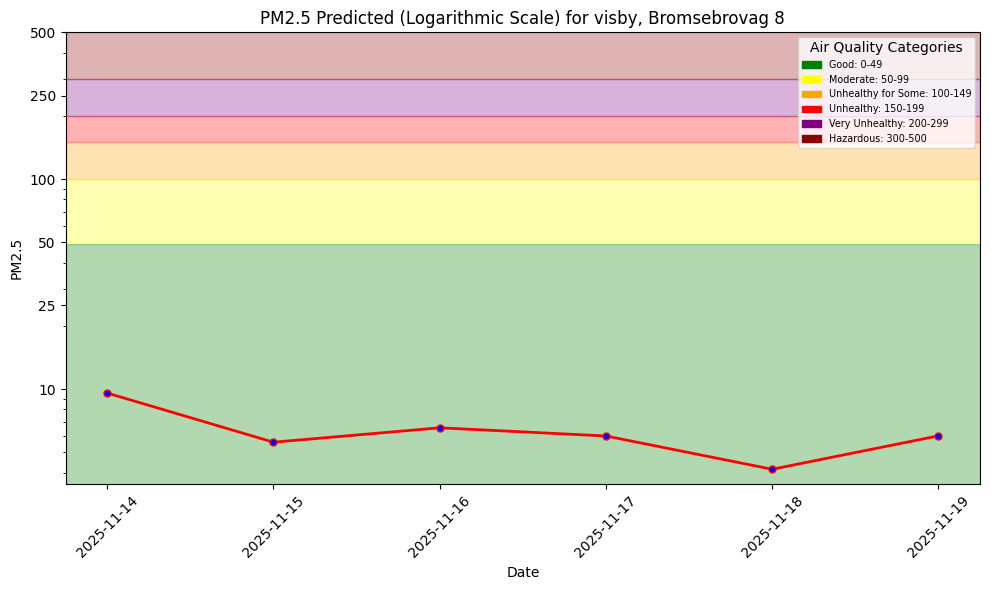

In [13]:

slug = SENSOR_SLUG
pred_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_forecast_{slug}.png"
plt = util.plot_air_quality_forecast(city, street, forecast_df, pred_file_path)

plt.show()

In [14]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='aq_predictions',
    description='Air Quality prediction monitoring',
    version=3,
    primary_key=['city','street','date','days_before_forecast_day'],
    event_time="date"
)

In [15]:
monitor_fg.insert(forecast_df, wait=True)

Uploading Dataframe: 100.00% |██████████| Rows 6/6 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271996/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-13 17:29:25,662 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-13 17:29:32,034 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 17:31:49,557 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 17:31:49,717 INFO: Waiting for log aggregation to finish.
2025-11-13 17:32:14,940 INFO: Execution finished successfully.


(Job('aq_predictions_3_offline_fg_materialization', 'SPARK'), None)

In [16]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.days_before_forecast_day == 1).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.04s) 


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,street,country,days_before_forecast_day
0,2025-11-14 00:00:00+00:00,5.50,0.0,11.681987,303.690094,visby,52.0,5.72,13.47,9.570483,Ostervag 17,Sweden,1
1,2025-11-18 00:00:00+00:00,2.50,0.0,18.998316,297.050507,ljugarn,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
2,2025-11-16 00:00:00+00:00,4.95,0.0,18.668005,230.477402,borgholm,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
3,2025-11-19 00:00:00+00:00,2.10,0.0,6.519877,276.340088,borgholm,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
4,2025-11-18 00:00:00+00:00,1.95,0.0,17.068707,297.645874,visby,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
5,2025-11-19 00:00:00+00:00,3.55,0.0,7.704336,232.594574,visby,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
6,2025-11-18 00:00:00+00:00,1.65,0.0,14.759999,282.680359,borgholm,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
7,2025-11-17 00:00:00+00:00,4.15,0.0,10.685391,327.380768,ljugarn,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
8,2025-11-17 00:00:00+00:00,3.70,0.0,9.511088,330.524200,visby,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1
9,2025-11-19 00:00:00+00:00,3.65,0.0,6.193674,234.462234,ljugarn,NaN,NaN,NaN,NaN,Ostervag 17,Sweden,1


In [17]:
air_quality_fg = fs.get_feature_group(name='air_quality', version=3)
# Filter outcomes to this sensor
air_quality_df = air_quality_fg.filter(
    (air_quality_fg.city == city) & (air_quality_fg.street == street) & (air_quality_fg.country == country)
).read()

air_quality_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.11s) 


,date,pm25,country,city,street,url,pm25_lag_1,pm25_lag_2,pm25_lag_3
0,2024-05-14 00:00:00+00:00,1.30,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,1.67,1.47,1.20
1,2022-10-25 00:00:00+00:00,3.27,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,5.50,2.40,9.75
2,2025-07-27 00:00:00+00:00,3.00,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,4.90,3.09,2.54
3,2020-08-27 00:00:00+00:00,0.63,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,1.30,0.60,1.10
4,2025-05-30 00:00:00+00:00,0.60,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,0.80,2.33,0.90
...,...,...,...,...,...,...,...,...,...
2152,2024-04-01 00:00:00+00:00,5.43,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,3.90,3.00,5.83
2153,2025-09-09 00:00:00+00:00,8.00,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,23.65,3.50,10.83
2154,2020-09-13 00:00:00+00:00,3.13,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,3.53,1.20,0.50
2155,2021-06-13 00:00:00+00:00,0.97,Sweden,visby,Bromsebrovag 8,https://api.waqi.info/feed/@13987,1.97,3.17,3.19


In [18]:
outcome_df = air_quality_df[['date', 'pm25']]
preds_df   = monitoring_df[['date', 'predicted_pm25']]

hindcast_df = pd.merge(preds_df, outcome_df, on="date")
hindcast_df = hindcast_df.sort_values(by=['date'])

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
if len(hindcast_df) == 0:
    hindcast_df = util.backfill_predictions_for_monitoring(weather_fg, air_quality_df, monitor_fg, retrieved_xgboost_model)

hindcast_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.94s) 


Uploading Dataframe: 100.00% |██████████| Rows 10/10 | Elapsed Time: 00:01 | Remaining Time: 00:00


Launching job: aq_predictions_3_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1271996/jobs/named/aq_predictions_3_offline_fg_materialization/executions
2025-11-13 17:32:37,599 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED
2025-11-13 17:32:40,780 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED
2025-11-13 17:34:06,928 INFO: Waiting for execution to finish. Current state: SUCCEEDING. Final status: UNDEFINED
2025-11-13 17:34:13,353 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED
2025-11-13 17:34:13,499 INFO: Waiting for log aggregation to finish.
2025-11-13 17:34:22,093 INFO: Execution finished successfully.


,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,pm25_lag_1,pm25_lag_2,pm25_lag_3,predicted_pm25,pm25,street,country,days_before_forecast_day
0,2025-11-16 00:00:00+00:00,4.95,0.0,18.668005,230.477402,borgholm,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
1,2025-11-17 00:00:00+00:00,2.75,0.0,11.165805,339.227661,borgholm,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
2,2025-11-17 00:00:00+00:00,3.70,0.0,9.511088,330.524200,visby,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
3,2025-11-17 00:00:00+00:00,4.15,0.0,10.685391,327.380768,ljugarn,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
4,2025-11-18 00:00:00+00:00,1.95,0.0,17.068707,297.645874,visby,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
5,2025-11-18 00:00:00+00:00,1.65,0.0,14.759999,282.680359,borgholm,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
6,2025-11-18 00:00:00+00:00,2.50,0.0,18.998316,297.050507,ljugarn,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
7,2025-11-19 00:00:00+00:00,3.55,0.0,7.704336,232.594574,visby,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
8,2025-11-19 00:00:00+00:00,2.10,0.0,6.519877,276.340088,borgholm,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1
9,2025-11-19 00:00:00+00:00,3.65,0.0,6.193674,234.462234,ljugarn,NaN,NaN,NaN,None,NaN,Bromsebrovag 8,Sweden,1


### Plot the Hindcast comparing predicted with forecasted values (1-day prior forecast)

__This graph will be empty to begin with - this is normal.__

After a few days of predictions and observations, you will get data points in this graph.

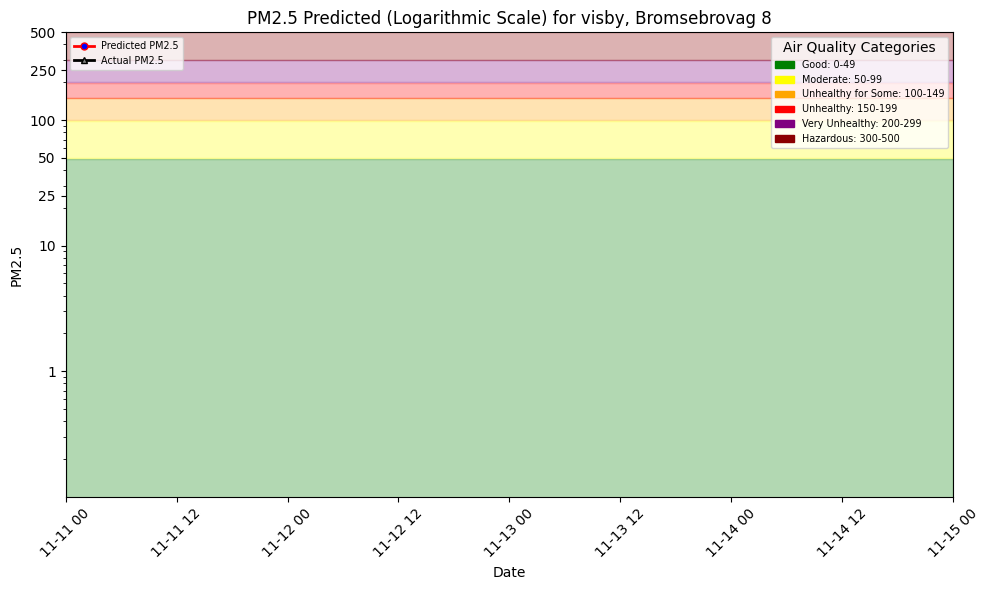

In [19]:
hindcast_file_path = f"{root_dir}/docs/air-quality/assets/img/pm25_hindcast_1day_{slug}.png"
plt = util.plot_air_quality_forecast(city, street, hindcast_df, hindcast_file_path, hindcast=True)



plt.show()

### Upload the prediction and hindcast dashboards (png files) to Hopsworks


In [20]:
dataset_api = project.get_dataset_api()
str_today = today.strftime("%Y-%m-%d")
if dataset_api.exists("Resources/airquality") == False:
    dataset_api.mkdir("Resources/airquality")
dataset_api.upload(pred_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)
dataset_api.upload(hindcast_file_path, f"Resources/airquality/{city}_{street}_{str_today}", overwrite=True)

proj_url = project.get_url()
print(f"See images in Hopsworks here: {proj_url}/settings/fb/path/Resources/airquality")

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/mlfs-book/docs/air-quality/assets/img/pm25_forecast_visby_bro…

Uploading /Users/jesper/Documents/KTH/Skalbar_ML/mlfs-book/docs/air-quality/assets/img/pm25_hindcast_1day_visb…

See images in Hopsworks here: https://c.app.hopsworks.ai:443/p/1271996/settings/fb/path/Resources/airquality


---